In [ ]:
from numpy.random import seed
seed(101)

import pandas as pd
import numpy as np

import tensorflow as tf
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

tf.random.set_seed(101)

import os

from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
import itertools
import shutil
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
# dataset_dir = '../../Documents/skin-cancer-mnist-ham10000/'
# base_dir = 'base_dir'
# train_dir = os.path.join(base_dir, 'train_dir')
# val_dir = os.path.join(base_dir, 'val_dir')

# df_data = pd.read_csv(dataset_dir + '/HAM10000_metadata.csv')

# # this will tell us how many images are associated with each lesion_id
# df = df_data.groupby('lesion_id').count()

# # now we filter out lesion_id's that have only one image associated with it
# df = df[df['image_id'] == 1]
# df.reset_index(inplace=True)


# # here we identify lesion_id's that have duplicate images and those that have only
# # one image.

# def identify_duplicates(x):
#     unique_list = list(df['lesion_id'])
    
#     if x in unique_list:
#         return 'no_duplicates'
#     else:
#         return 'has_duplicates'
    
# # create a new colum that is a copy of the lesion_id column
# df_data['duplicates'] = df_data['lesion_id']
# # apply the function to this new column
# df_data['duplicates'] = df_data['duplicates'].apply(identify_duplicates)

# # now we filter out images that don't have duplicates
# df = df_data[df_data['duplicates'] == 'no_duplicates']

# # now we create a val set using df because we are sure that none of these images
# # have augmented duplicates in the train set
# y = df['dx']

# _, df_val = train_test_split(df, test_size=0.17, random_state=101, stratify=y)

# # This set will be df_data excluding all rows that are in the val set

# # This function identifies if an image is part of the train
# # or val set.
# def identify_val_rows(x):
#     # create a list of all the lesion_id's in the val set
#     val_list = list(df_val['image_id'])
    
#     if str(x) in val_list:
#         return 'val'
#     else:
#         return 'train'

# # identify train and val rows

# # create a new colum that is a copy of the image_id column
# df_data['train_or_val'] = df_data['image_id']
# # apply the function to this new column
# df_data['train_or_val'] = df_data['train_or_val'].apply(identify_val_rows)
   
# # filter out train rows
# df_train = df_data[df_data['train_or_val'] == 'train']


# print(len(df_train))
# print(len(df_val))

In [ ]:
# for v2

dataset_dir = '../../Documents/skin-cancer-mnist-ham10000/'
base_dir = 'base_dir_v2'
train_dir = os.path.join(base_dir, 'train_dir')
val_dir = os.path.join(base_dir, 'val_dir')

df_data = pd.read_csv(dataset_dir + '/HAM10000_metadata.csv')


#X = df_data.drop('dx', axis=1)
y = df_data['dx']

df_train, df_val = train_test_split(df_data, test_size=0.1, random_state=101, stratify=y)

print(df_train.shape)
print(df_val.shape)

In [ ]:
train_path = base_dir + '/train_dir'
valid_path = base_dir + '/val_dir'

num_train_samples = len(df_train)
num_val_samples = len(df_val)
train_batch_size = 10
val_batch_size = 10
image_size = 224

train_steps = np.ceil(num_train_samples / train_batch_size)
val_steps = np.ceil(num_val_samples / val_batch_size)


datagen = ImageDataGenerator(
    preprocessing_function= \
    tf.keras.applications.mobilenet.preprocess_input)

train_batches = datagen.flow_from_directory(train_path,
                                            target_size=(image_size,image_size),
                                            batch_size=train_batch_size)

valid_batches = datagen.flow_from_directory(valid_path,
                                            target_size=(image_size,image_size),
                                            batch_size=val_batch_size)

# Note: shuffle=False causes the test dataset to not be shuffled
test_batches = datagen.flow_from_directory(valid_path,
                                            target_size=(image_size,image_size),
                                            batch_size=1,
                                            shuffle=False)

from tensorflow.keras.metrics import categorical_accuracy, top_k_categorical_accuracy

def top_3_accuracy(y_true, y_pred):
    return top_k_categorical_accuracy(y_true, y_pred, k=3)

def top_2_accuracy(y_true, y_pred):
    return top_k_categorical_accuracy(y_true, y_pred, k=2)

class_weights = {
    0: 1.0, # akiec
    1: 1.0, # bcc
    2: 1.0, # bkl
    3: 1.0, # df
    4: 3.0, # mel # Try to make the model more sensitive to Melanoma.
    5: 1.0, # nv
    6: 1.0, # vasc
}

In [ ]:
# create a copy of a mobilenet model
mobile = tf.keras.applications.mobilenet.MobileNet()

mobile.summary()
print(type(mobile.layers))
# How many layers does MobileNet have?
print(len(mobile.layers))

# CREATE THE MODEL ARCHITECTURE

# Exclude the last 5 layers of the above model.
# This will include all layers up to and including global_average_pooling2d_1
x = mobile.layers[-6].output

# Create a new dense layer for predictions
# 7 corresponds to the number of classes
x = Dropout(0.25)(x)
predictions = Dense(7, activation='softmax')(x)

# inputs=mobile.input selects the input layer, outputs=predictions refers to the
# dense layer we created above.

model = Model(inputs=mobile.input, outputs=predictions)

# We need to choose how many layers we actually want to be trained.

# Here we are freezing the weights of all layers except the
# last 23 layers in the new model.
# The last 23 layers of the model will be trained.

for layer in model.layers[:-23]:
    layer.trainable = False

In [ ]:
model.compile(Adam(lr=0.01), loss='categorical_crossentropy', 
              metrics=[categorical_accuracy, top_2_accuracy, top_3_accuracy])

filepath = "mobilenet_model.h5"
checkpoint = ModelCheckpoint(filepath, monitor='val_categorical_accuracy', verbose=1, 
                             save_best_only=True, mode='max')

reduce_lr = ReduceLROnPlateau(monitor='val_categorical_accuracy', factor=0.5, patience=2, 
                                   verbose=1, mode='max', min_lr=0.00001)
                              
                              
callbacks_list = [checkpoint, reduce_lr]

history = model.fit_generator(train_batches, steps_per_epoch=train_steps, 
                              class_weight=class_weights,
                    validation_data=valid_batches,
                    validation_steps=val_steps,
                    epochs=30, verbose=1,
                   callbacks=callbacks_list)


In [ ]:
# Here the the last epoch will be used.

val_loss, val_cat_acc, val_top_2_acc, val_top_3_acc = \
model.evaluate_generator(test_batches, 
                        steps=len(df_val))

print('val_loss:', val_loss)
print('val_cat_acc:', val_cat_acc)
print('val_top_2_acc:', val_top_2_acc)
print('val_top_3_acc:', val_top_3_acc)

In [ ]:
# Here the best epoch will be used.

model.load_weights('mobilenet_model.h5')

val_loss, val_cat_acc, val_top_2_acc, val_top_3_acc = \
model.evaluate_generator(test_batches, 
                        steps=len(df_val))

print('val_loss:', val_loss)
print('val_cat_acc:', val_cat_acc)
print('val_top_2_acc:', val_top_2_acc)
print('val_top_3_acc:', val_top_3_acc)

In [ ]:
# display the loss and accuracy curves
acc = history.history['categorical_accuracy']
val_acc = history.history['val_categorical_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
train_top2_acc = history.history['top_2_accuracy']
val_top2_acc = history.history['val_top_2_accuracy']
train_top3_acc = history.history['top_3_accuracy']
val_top3_acc = history.history['val_top_3_accuracy']
epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.figure()

plt.plot(epochs, acc, 'bo', label='Training cat acc')
plt.plot(epochs, val_acc, 'b', label='Validation cat acc')
plt.title('Training and validation cat accuracy')
plt.legend()
plt.figure()


plt.plot(epochs, train_top2_acc, 'bo', label='Training top2 acc')
plt.plot(epochs, val_top2_acc, 'b', label='Validation top2 acc')
plt.title('Training and validation top2 accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, train_top3_acc, 'bo', label='Training top3 acc')
plt.plot(epochs, val_top3_acc, 'b', label='Validation top3 acc')
plt.title('Training and validation top3 accuracy')
plt.legend()


plt.show()

In [4]:
def train_mobilenet_v2(last_layers_training=-1):
    IMG_SHAPE = (224, 224, 3)

    # Create the base model from the pre-trained model MobileNet V2
    mobilev2 = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                                   weights='imagenet')
#     mobilev2.summary()
#     print(len(mobilev2.layers))

    x = mobilev2.layers[-2].output
    predictions = Dense(7, activation='softmax')(x)
    model = Model(inputs=mobilev2.input, outputs=predictions)

    for layer in model.layers[:last_layers_training]:
        layer.trainable = False
        
    base_learning_rate = 0.0001

    model.compile(Adam(lr=0.01), loss='categorical_crossentropy', 
                  metrics=[categorical_accuracy, top_2_accuracy, top_3_accuracy])

    filepath = "mobilenetv2_model_" + str(last_layers_training) + ".h5"
    checkpoint = ModelCheckpoint(filepath, monitor='val_categorical_accuracy', verbose=1, 
                                 save_best_only=True, mode='max')

    reduce_lr = ReduceLROnPlateau(monitor='val_categorical_accuracy', factor=0.5, patience=2, 
                                       verbose=1, mode='max', min_lr=0.00001)


    callbacks_list = [checkpoint, reduce_lr]

    history = model.fit_generator(train_batches, steps_per_epoch=train_steps, 
                                  class_weight=class_weights,
                        validation_data=valid_batches,
                        validation_steps=val_steps,
                        epochs=20, verbose=1,
                       callbacks=callbacks_list)
    
    # Here the best epoch will be used.
    model.load_weights(filepath)

    val_loss, val_cat_acc, val_top_2_acc, val_top_3_acc = \
    model.evaluate_generator(test_batches, 
                            steps=len(df_val))

    print('val_loss:', val_loss)
    print('val_cat_acc:', val_cat_acc)
    print('val_top_2_acc:', val_top_2_acc)
    print('val_top_3_acc:', val_top_3_acc)

    acc = history.history['categorical_accuracy']
    val_acc = history.history['val_categorical_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    train_top2_acc = history.history['top_2_accuracy']
    val_top2_acc = history.history['val_top_2_accuracy']
    train_top3_acc = history.history['top_3_accuracy']
    val_top3_acc = history.history['val_top_3_accuracy']
    epochs = range(1, len(acc) + 1)

    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()
    plt.figure()

    plt.plot(epochs, acc, 'bo', label='Training cat acc')
    plt.plot(epochs, val_acc, 'b', label='Validation cat acc')
    plt.title('Training and validation cat accuracy')
    plt.legend()
    plt.figure()


    plt.plot(epochs, train_top2_acc, 'bo', label='Training top2 acc')
    plt.plot(epochs, val_top2_acc, 'b', label='Validation top2 acc')
    plt.title('Training and validation top2 accuracy')
    plt.legend()
    plt.figure()
    plt.plot(epochs, train_top3_acc, 'bo', label='Training top3 acc')
    plt.plot(epochs, val_top3_acc, 'b', label='Validation top3 acc')
    plt.title('Training and validation top3 accuracy')
    plt.legend()

    plt.show()

Epoch 1/20
901/902 [============================>.] - ETA: 0s - loss: 2.0589 - categorical_accuracy: 0.3474 - top_2_accuracy: 0.5415 - top_3_accuracy: 0.6956
Epoch 00001: val_categorical_accuracy improved from -inf to 0.10978, saving model to mobilenetv2_model_-103.h5
902/902 [==============================] - 197s 218ms/step - loss: 2.0583 - categorical_accuracy: 0.3476 - top_2_accuracy: 0.5416 - top_3_accuracy: 0.6955 - val_loss: 13.5726 - val_categorical_accuracy: 0.1098 - val_top_2_accuracy: 0.1737 - val_top_3_accuracy: 0.2685
Epoch 2/20
901/902 [============================>.] - ETA: 0s - loss: 1.5950 - categorical_accuracy: 0.4799 - top_2_accuracy: 0.6900 - top_3_accuracy: 0.8280
Epoch 00002: val_categorical_accuracy did not improve from 0.10978
902/902 [==============================] - 186s 206ms/step - loss: 1.5950 - categorical_accuracy: 0.4798 - top_2_accuracy: 0.6899 - top_3_accuracy: 0.8279 - val_loss: 11.4041 - val_categorical_accuracy: 0.1038 - val_top_2_accuracy: 0.2096

Epoch 17/20
901/902 [============================>.] - ETA: 0s - loss: 0.8674 - categorical_accuracy: 0.7272 - top_2_accuracy: 0.8993 - top_3_accuracy: 0.9628
Epoch 00017: val_categorical_accuracy did not improve from 0.69760

Epoch 00017: ReduceLROnPlateau reducing learning rate to 0.0003124999930150807.
902/902 [==============================] - 181s 201ms/step - loss: 0.8670 - categorical_accuracy: 0.7274 - top_2_accuracy: 0.8994 - top_3_accuracy: 0.9629 - val_loss: 1.2908 - val_categorical_accuracy: 0.5289 - val_top_2_accuracy: 0.7515 - val_top_3_accuracy: 0.8723
Epoch 18/20
901/902 [============================>.] - ETA: 0s - loss: 0.8249 - categorical_accuracy: 0.7370 - top_2_accuracy: 0.9044 - top_3_accuracy: 0.9660 ETA: 3s - loss: 0.8212 - categorical_accuracy: 0.7379 - top_2_accurac
Epoch 00018: val_categorical_accuracy did not improve from 0.69760
902/902 [==============================] - 182s 202ms/step - loss: 0.8252 - categorical_accuracy: 0.7369 - top_2_accuracy: 0.9043 

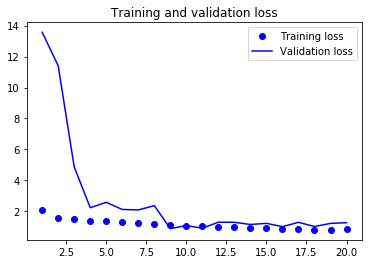

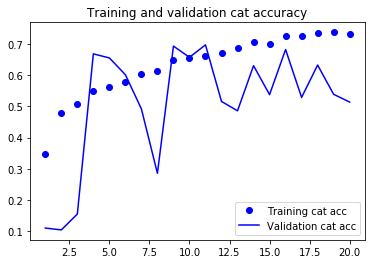

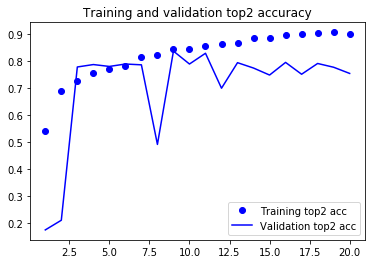

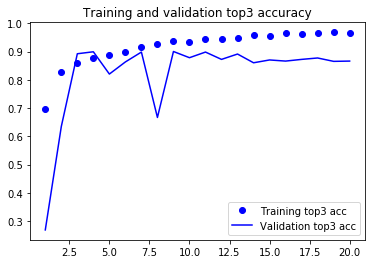

Epoch 1/20
901/902 [============================>.] - ETA: 0s - loss: 2.3926 - categorical_accuracy: 0.2895 - top_2_accuracy: 0.4885 - top_3_accuracy: 0.6374
Epoch 00001: val_categorical_accuracy improved from -inf to 0.11377, saving model to mobilenetv2_model_-112.h5
902/902 [==============================] - 188s 209ms/step - loss: 2.3918 - categorical_accuracy: 0.2899 - top_2_accuracy: 0.4888 - top_3_accuracy: 0.6376 - val_loss: 2.1808 - val_categorical_accuracy: 0.1138 - val_top_2_accuracy: 0.7804 - val_top_3_accuracy: 0.8164
Epoch 2/20
901/902 [============================>.] - ETA: 0s - loss: 1.6743 - categorical_accuracy: 0.4435 - top_2_accuracy: 0.6607 - top_3_accuracy: 0.8000
Epoch 00002: val_categorical_accuracy improved from 0.11377 to 0.66966, saving model to mobilenetv2_model_-112.h5
902/902 [==============================] - 185s 205ms/step - loss: 1.6747 - categorical_accuracy: 0.4438 - top_2_accuracy: 0.6610 - top_3_accuracy: 0.8001 - val_loss: 4.0448 - val_categorical_

Epoch 17/20
901/902 [============================>.] - ETA: 0s - loss: 0.8220 - categorical_accuracy: 0.7289 - top_2_accuracy: 0.8968 - top_3_accuracy: 0.9678
Epoch 00017: val_categorical_accuracy did not improve from 0.70958
902/902 [==============================] - 187s 207ms/step - loss: 0.8225 - categorical_accuracy: 0.7285 - top_2_accuracy: 0.8969 - top_3_accuracy: 0.9678 - val_loss: 1.0035 - val_categorical_accuracy: 0.6866 - val_top_2_accuracy: 0.8064 - val_top_3_accuracy: 0.8762
Epoch 18/20
901/902 [============================>.] - ETA: 0s - loss: 0.7883 - categorical_accuracy: 0.7472 - top_2_accuracy: 0.9081 - top_3_accuracy: 0.9701
Epoch 00018: val_categorical_accuracy did not improve from 0.70958

Epoch 00018: ReduceLROnPlateau reducing learning rate to 7.812499825377017e-05.
902/902 [==============================] - 186s 206ms/step - loss: 0.7884 - categorical_accuracy: 0.7471 - top_2_accuracy: 0.9080 - top_3_accuracy: 0.9701 - val_loss: 0.9688 - val_categorical_accuracy

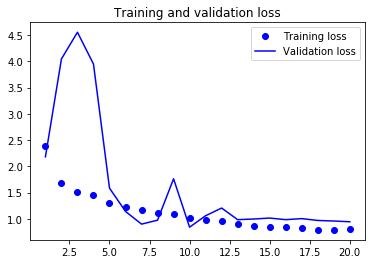

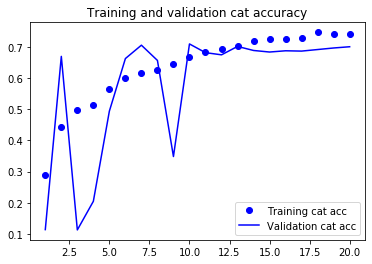

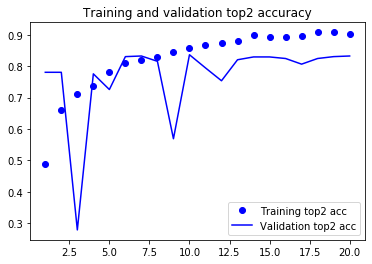

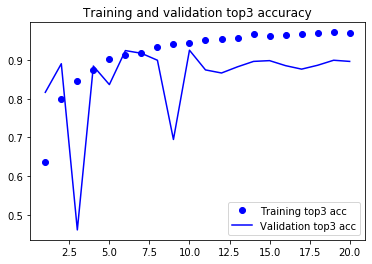

Epoch 1/20
901/902 [============================>.] - ETA: 0s - loss: 2.2992 - categorical_accuracy: 0.2991 - top_2_accuracy: 0.4900 - top_3_accuracy: 0.6466
Epoch 00001: val_categorical_accuracy improved from -inf to 0.10679, saving model to mobilenetv2_model_-121.h5
902/902 [==============================] - 192s 212ms/step - loss: 2.2988 - categorical_accuracy: 0.2991 - top_2_accuracy: 0.4899 - top_3_accuracy: 0.6463 - val_loss: 12.8016 - val_categorical_accuracy: 0.1068 - val_top_2_accuracy: 0.1896 - val_top_3_accuracy: 0.2445
Epoch 2/20
901/902 [============================>.] - ETA: 0s - loss: 1.6835 - categorical_accuracy: 0.4336 - top_2_accuracy: 0.6523 - top_3_accuracy: 0.7905
Epoch 00002: val_categorical_accuracy improved from 0.10679 to 0.19960, saving model to mobilenetv2_model_-121.h5
902/902 [==============================] - 191s 212ms/step - loss: 1.6834 - categorical_accuracy: 0.4338 - top_2_accuracy: 0.6524 - top_3_accuracy: 0.7905 - val_loss: 7.6799 - val_categorical

Epoch 17/20
901/902 [============================>.] - ETA: 0s - loss: 0.8851 - categorical_accuracy: 0.7139 - top_2_accuracy: 0.8872 - top_3_accuracy: 0.9570
Epoch 00017: val_categorical_accuracy did not improve from 0.68463

Epoch 00017: ReduceLROnPlateau reducing learning rate to 0.0006249999860301614.
902/902 [==============================] - 190s 211ms/step - loss: 0.8850 - categorical_accuracy: 0.7139 - top_2_accuracy: 0.8874 - top_3_accuracy: 0.9571 - val_loss: 1.7950 - val_categorical_accuracy: 0.6707 - val_top_2_accuracy: 0.7016 - val_top_3_accuracy: 0.8024
Epoch 18/20
901/902 [============================>.] - ETA: 0s - loss: 0.8219 - categorical_accuracy: 0.7337 - top_2_accuracy: 0.9057 - top_3_accuracy: 0.9650
Epoch 00018: val_categorical_accuracy did not improve from 0.68463
902/902 [==============================] - 192s 212ms/step - loss: 0.8215 - categorical_accuracy: 0.7337 - top_2_accuracy: 0.9058 - top_3_accuracy: 0.9651 - val_loss: 1.6415 - val_categorical_accuracy

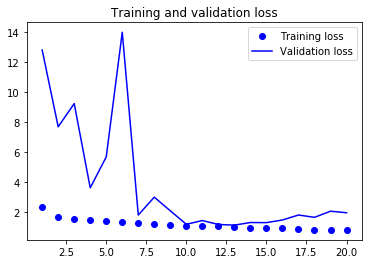

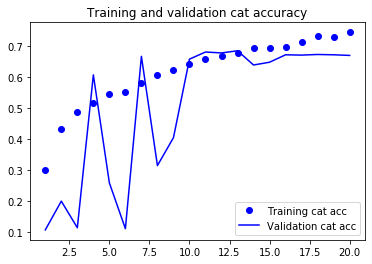

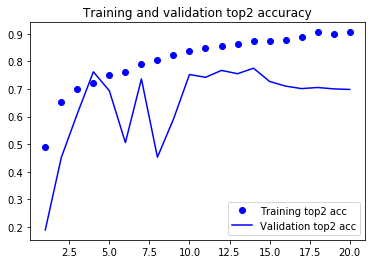

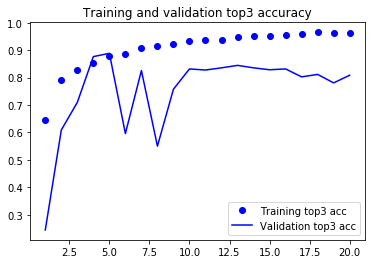

Epoch 1/20
901/902 [============================>.] - ETA: 0s - loss: 3.4956 - categorical_accuracy: 0.1859 - top_2_accuracy: 0.3660 - top_3_accuracy: 0.5360
Epoch 00001: val_categorical_accuracy improved from -inf to 0.66966, saving model to mobilenetv2_model_-130.h5
902/902 [==============================] - 193s 214ms/step - loss: 3.4958 - categorical_accuracy: 0.1858 - top_2_accuracy: 0.3659 - top_3_accuracy: 0.5359 - val_loss: 5.2823 - val_categorical_accuracy: 0.6697 - val_top_2_accuracy: 1.0000 - val_top_3_accuracy: 1.0000
Epoch 2/20
901/902 [============================>.] - ETA: 0s - loss: 3.1365 - categorical_accuracy: 0.2070 - top_2_accuracy: 0.3851 - top_3_accuracy: 0.5436
Epoch 00002: val_categorical_accuracy did not improve from 0.66966
902/902 [==============================] - 193s 214ms/step - loss: 3.1347 - categorical_accuracy: 0.2072 - top_2_accuracy: 0.3852 - top_3_accuracy: 0.5438 - val_loss: 6.4496 - val_categorical_accuracy: 0.0279 - val_top_2_accuracy: 0.0828 -

902/902 [==============================] - 195s 216ms/step - loss: 1.1308 - categorical_accuracy: 0.6228 - top_2_accuracy: 0.8221 - top_3_accuracy: 0.9237 - val_loss: 1.2613 - val_categorical_accuracy: 0.6727 - val_top_2_accuracy: 0.7425 - val_top_3_accuracy: 0.8004
Epoch 17/20
901/902 [============================>.] - ETA: 0s - loss: 1.1510 - categorical_accuracy: 0.6163 - top_2_accuracy: 0.8178 - top_3_accuracy: 0.9218
Epoch 00017: val_categorical_accuracy did not improve from 0.67265
902/902 [==============================] - 193s 214ms/step - loss: 1.1508 - categorical_accuracy: 0.6164 - top_2_accuracy: 0.8178 - top_3_accuracy: 0.9217 - val_loss: 1.3496 - val_categorical_accuracy: 0.6477 - val_top_2_accuracy: 0.7156 - val_top_3_accuracy: 0.7794
Epoch 18/20
901/902 [============================>.] - ETA: 0s - loss: 1.1324 - categorical_accuracy: 0.6183 - top_2_accuracy: 0.8208 - top_3_accuracy: 0.9242
Epoch 00018: val_categorical_accuracy did not improve from 0.67265

Epoch 00018: 

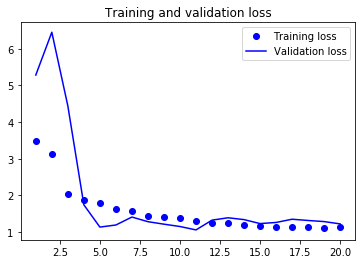

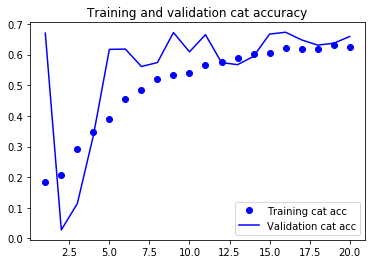

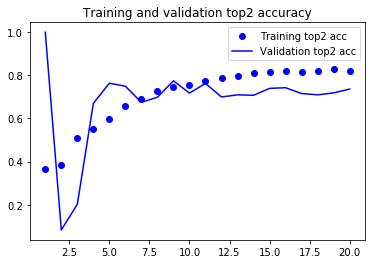

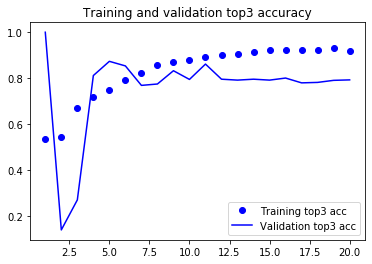

Epoch 1/20
901/902 [============================>.] - ETA: 0s - loss: 3.4573 - categorical_accuracy: 0.1646 - top_2_accuracy: 0.3548 - top_3_accuracy: 0.5421
Epoch 00001: val_categorical_accuracy improved from -inf to 0.11078, saving model to mobilenetv2_model_-139.h5
902/902 [==============================] - 201s 223ms/step - loss: 3.4559 - categorical_accuracy: 0.1645 - top_2_accuracy: 0.3545 - top_3_accuracy: 0.5421 - val_loss: 7.6945 - val_categorical_accuracy: 0.1108 - val_top_2_accuracy: 0.1248 - val_top_3_accuracy: 0.2345
Epoch 2/20
901/902 [============================>.] - ETA: 0s - loss: 2.0558 - categorical_accuracy: 0.2906 - top_2_accuracy: 0.4993 - top_3_accuracy: 0.6609
Epoch 00002: val_categorical_accuracy improved from 0.11078 to 0.11377, saving model to mobilenetv2_model_-139.h5
902/902 [==============================] - 200s 221ms/step - loss: 2.0555 - categorical_accuracy: 0.2906 - top_2_accuracy: 0.4996 - top_3_accuracy: 0.6611 - val_loss: 5.9769 - val_categorical_

Epoch 17/20
901/902 [============================>.] - ETA: 0s - loss: 1.0677 - categorical_accuracy: 0.6446 - top_2_accuracy: 0.8491 - top_3_accuracy: 0.9368
Epoch 00017: val_categorical_accuracy did not improve from 0.66966
902/902 [==============================] - 199s 221ms/step - loss: 1.0681 - categorical_accuracy: 0.6444 - top_2_accuracy: 0.8488 - top_3_accuracy: 0.9367 - val_loss: 1.8903 - val_categorical_accuracy: 0.6617 - val_top_2_accuracy: 0.7186 - val_top_3_accuracy: 0.7894
Epoch 18/20
901/902 [============================>.] - ETA: 0s - loss: 1.0270 - categorical_accuracy: 0.6600 - top_2_accuracy: 0.8548 - top_3_accuracy: 0.9382
Epoch 00018: val_categorical_accuracy did not improve from 0.66966

Epoch 00018: ReduceLROnPlateau reducing learning rate to 0.00015624999650754035.
902/902 [==============================] - 201s 223ms/step - loss: 1.0269 - categorical_accuracy: 0.6600 - top_2_accuracy: 0.8550 - top_3_accuracy: 0.9382 - val_loss: 1.8792 - val_categorical_accurac

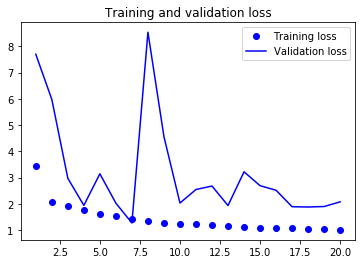

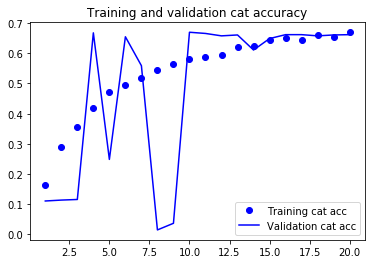

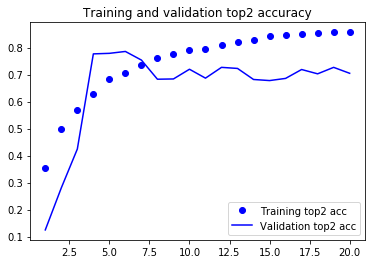

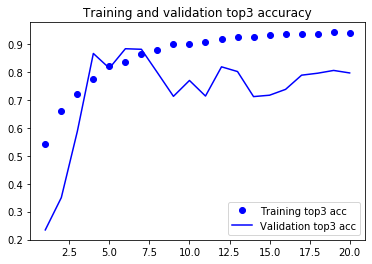

Epoch 1/20
901/902 [============================>.] - ETA: 0s - loss: 2.3737 - categorical_accuracy: 0.2413 - top_2_accuracy: 0.4453 - top_3_accuracy: 0.6071
Epoch 00001: val_categorical_accuracy improved from -inf to 0.03693, saving model to mobilenetv2_model_-148.h5
902/902 [==============================] - 206s 228ms/step - loss: 2.3733 - categorical_accuracy: 0.2414 - top_2_accuracy: 0.4453 - top_3_accuracy: 0.6072 - val_loss: 8.7958 - val_categorical_accuracy: 0.0369 - val_top_2_accuracy: 0.6816 - val_top_3_accuracy: 0.7914
Epoch 2/20
901/902 [============================>.] - ETA: 0s - loss: 1.9775 - categorical_accuracy: 0.3073 - top_2_accuracy: 0.5425 - top_3_accuracy: 0.6984
Epoch 00002: val_categorical_accuracy did not improve from 0.03693
902/902 [==============================] - 205s 228ms/step - loss: 1.9772 - categorical_accuracy: 0.3072 - top_2_accuracy: 0.5426 - top_3_accuracy: 0.6983 - val_loss: 15.8661 - val_categorical_accuracy: 0.0140 - val_top_2_accuracy: 0.6836 

Epoch 17/20
901/902 [============================>.] - ETA: 0s - loss: 1.0748 - categorical_accuracy: 0.6436 - top_2_accuracy: 0.8418 - top_3_accuracy: 0.9335
Epoch 00017: val_categorical_accuracy did not improve from 0.54790
902/902 [==============================] - 204s 226ms/step - loss: 1.0745 - categorical_accuracy: 0.6436 - top_2_accuracy: 0.8418 - top_3_accuracy: 0.9335 - val_loss: 4.1649 - val_categorical_accuracy: 0.0539 - val_top_2_accuracy: 0.1936 - val_top_3_accuracy: 0.3034
Epoch 18/20
901/902 [============================>.] - ETA: 0s - loss: 1.0791 - categorical_accuracy: 0.6455 - top_2_accuracy: 0.8418 - top_3_accuracy: 0.9347
Epoch 00018: val_categorical_accuracy did not improve from 0.54790

Epoch 00018: ReduceLROnPlateau reducing learning rate to 0.00015624999650754035.
902/902 [==============================] - 204s 226ms/step - loss: 1.0798 - categorical_accuracy: 0.6452 - top_2_accuracy: 0.8415 - top_3_accuracy: 0.9343 - val_loss: 4.1505 - val_categorical_accurac

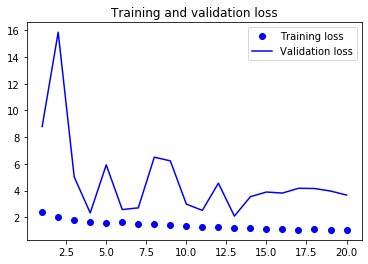

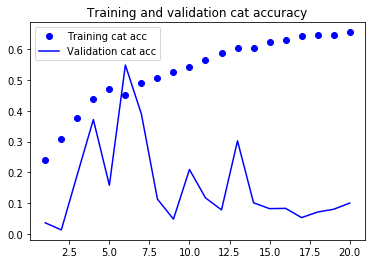

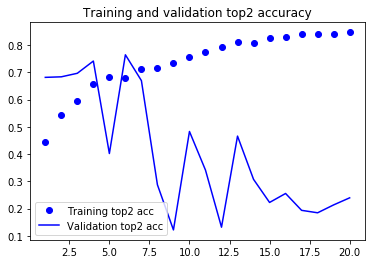

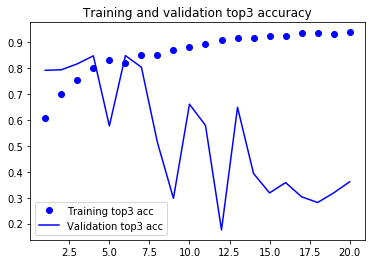

Epoch 1/20
901/902 [============================>.] - ETA: 0s - loss: 2.8379 - categorical_accuracy: 0.1550 - top_2_accuracy: 0.3137 - top_3_accuracy: 0.4747
Epoch 00001: val_categorical_accuracy improved from -inf to 0.04291, saving model to mobilenetv2_model_-157.h5
902/902 [==============================] - 207s 230ms/step - loss: 2.8373 - categorical_accuracy: 0.1550 - top_2_accuracy: 0.3135 - top_3_accuracy: 0.4746 - val_loss: 3.4103 - val_categorical_accuracy: 0.0429 - val_top_2_accuracy: 0.1267 - val_top_3_accuracy: 0.4691
Epoch 2/20
901/902 [============================>.] - ETA: 0s - loss: 2.3559 - categorical_accuracy: 0.1504 - top_2_accuracy: 0.3081 - top_3_accuracy: 0.4681
Epoch 00002: val_categorical_accuracy improved from 0.04291 to 0.66467, saving model to mobilenetv2_model_-157.h5
902/902 [==============================] - 208s 231ms/step - loss: 2.3562 - categorical_accuracy: 0.1505 - top_2_accuracy: 0.3081 - top_3_accuracy: 0.4680 - val_loss: 1.6824 - val_categorical_

Epoch 17/20
901/902 [============================>.] - ETA: 0s - loss: 1.1322 - categorical_accuracy: 0.6114 - top_2_accuracy: 0.8275 - top_3_accuracy: 0.9279
Epoch 00017: val_categorical_accuracy did not improve from 0.69960
902/902 [==============================] - 206s 228ms/step - loss: 1.1320 - categorical_accuracy: 0.6114 - top_2_accuracy: 0.8275 - top_3_accuracy: 0.9279 - val_loss: 0.7847 - val_categorical_accuracy: 0.6896 - val_top_2_accuracy: 0.8593 - val_top_3_accuracy: 0.9471
Epoch 18/20
901/902 [============================>.] - ETA: 0s - loss: 1.0950 - categorical_accuracy: 0.6313 - top_2_accuracy: 0.8345 - top_3_accuracy: 0.9302
Epoch 00018: val_categorical_accuracy did not improve from 0.69960

Epoch 00018: ReduceLROnPlateau reducing learning rate to 0.00015624999650754035.
902/902 [==============================] - 206s 229ms/step - loss: 1.0950 - categorical_accuracy: 0.6313 - top_2_accuracy: 0.8344 - top_3_accuracy: 0.9303 - val_loss: 0.7930 - val_categorical_accurac

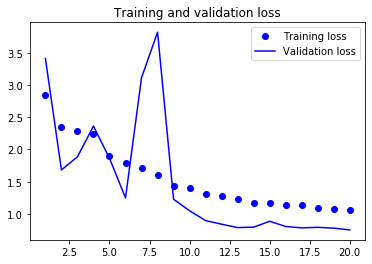

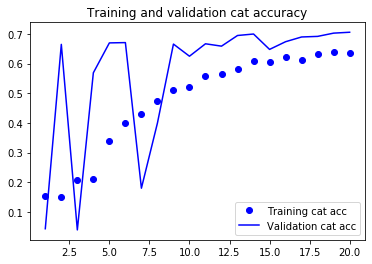

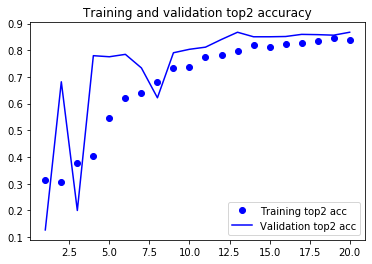

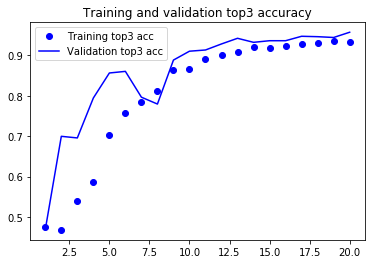

In [18]:
# train_mobilenet_v2(last_layers_training=-5) # lock until last 5 layers
# train_mobilenet_v2(last_layers_training=-13) # lock until last 5 layers + block_16

# for i in range(1, 10): # lock until last 5 layers + block_16 + block_15 ~ block_6  
#     train_mobilenet_v2(last_layers_training=-13-9*i)
for i in range(10, 16):
    train_mobilenet_v2(last_layers_training=-13-9*i)
    
train_mobilenet_v2(last_layers_training=-157)

In [ ]:
from MobileNet_V3 import build_mobilenet_v3
model = build_mobilenet_v3(input_size=224, num_classes=7, model_type='small', pooling_type='avg', include_top=True)

print(model.summary())
print(len(model.layers))

In [ ]:
base_learning_rate = 0.0001

model.compile(Adam(lr=0.1), loss='categorical_crossentropy', 
              metrics=[categorical_accuracy, top_2_accuracy, top_3_accuracy])

filepath = "mobilenetv3_model.h5"
checkpoint = ModelCheckpoint(filepath, monitor='val_categorical_accuracy', verbose=1, 
                             save_best_only=True, mode='max')

reduce_lr = ReduceLROnPlateau(monitor='val_categorical_accuracy', factor=0.5, patience=2, 
                                   verbose=1, mode='max', min_lr=0.00001)

callbacks_list = [checkpoint]
history = model.fit_generator(train_batches, steps_per_epoch=train_steps, 
                              class_weight=class_weights,
                    validation_data=valid_batches,
                    validation_steps=val_steps,
                    epochs=80, verbose=1,
                   callbacks=callbacks_list)

In [ ]:
# Here the best epoch will be used.

model.load_weights(filepath)

val_loss, val_cat_acc, val_top_2_acc, val_top_3_acc = \
model.evaluate_generator(test_batches, 
                        steps=len(df_val))

print('val_loss:', val_loss)
print('val_cat_acc:', val_cat_acc)
print('val_top_2_acc:', val_top_2_acc)
print('val_top_3_acc:', val_top_3_acc)

acc = history.history['categorical_accuracy']
val_acc = history.history['val_categorical_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
train_top2_acc = history.history['top_2_accuracy']
val_top2_acc = history.history['val_top_2_accuracy']
train_top3_acc = history.history['top_3_accuracy']
val_top3_acc = history.history['val_top_3_accuracy']
epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.figure()

plt.plot(epochs, acc, 'bo', label='Training cat acc')
plt.plot(epochs, val_acc, 'b', label='Validation cat acc')
plt.title('Training and validation cat accuracy')
plt.legend()
plt.figure()


plt.plot(epochs, train_top2_acc, 'bo', label='Training top2 acc')
plt.plot(epochs, val_top2_acc, 'b', label='Validation top2 acc')
plt.title('Training and validation top2 accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, train_top3_acc, 'bo', label='Training top3 acc')
plt.plot(epochs, val_top3_acc, 'b', label='Validation top3 acc')
plt.title('Training and validation top3 accuracy')
plt.legend()


plt.show()